In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import matplotlib.pyplot as plt

### Data Importing and Preprocessing

In [29]:
# The entire data is stored in a numpy array. The size of the images and corresponding masks have been reduced to 380 X 194.

# Replace the path by the path to the numpy array.

# In order to work with bigger images, make a DataSet object to directly read and process from the data folders.

data = np.load("/kaggle/input/spine-dataset/dataset.npz")

In [31]:
# These are the segmentation masks 

data.files

['lat_vertebra',
 'lat_ant_line',
 'ap_spinous',
 'ap_pedicle',
 'labels',
 'lat_post_line',
 'ap',
 'lat_spinous',
 'lat_disk_height',
 'lat',
 'ap_vertebra']

In [4]:
# The shape of the images

ap_shapes = data["ap"].shape
print(ap_shapes)
lat_shapes = data["lat"].shape
print(lat_shapes)

(626, 380, 194)
(626, 380, 194)


In [32]:
# Here, we are combining all the different inputs and outputs into single arrays.

ap_inp = data["ap"]
ap_inp = np.reshape(ap_inp, (ap_shapes[0], ap_shapes[1], ap_shapes[2], 1))
lat_inp = data["lat"]
lat_inp = np.reshape(lat_inp, (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1))


## NOTE:
# In this case the code for combining all 5 output segmentations for the LAT images is commented out.
# The LAT OUT Segmentations masks do not contain the anterior and posterior lines.

# In order to include these 2 masks as well, comment the last line and uncomment the second last line


ap_out = np.concatenate((np.reshape(data["ap_pedicle"], (ap_shapes[0], ap_shapes[1], ap_shapes[2], 1)), np.reshape(data["ap_spinous"], (ap_shapes[0], ap_shapes[1], ap_shapes[2], 1)), np.reshape(data["ap_spinous"], (ap_shapes[0], ap_shapes[1], ap_shapes[2], 1))), axis = -1)
# lat_out = np.concatenate((np.reshape(data["lat_ant_line"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1)), np.reshape(data["lat_post_line"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1)), np.reshape(data["lat_disk_height"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1)), np.reshape(data["lat_spinous"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1)), np.reshape(data["lat_vertebra"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1))), axis = -1)
lat_out = np.concatenate((np.reshape(data["lat_disk_height"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1)), np.reshape(data["lat_spinous"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1)), np.reshape(data["lat_vertebra"], (lat_shapes[0], lat_shapes[1], lat_shapes[2], 1))), axis = -1)

In [6]:
# Checking the size of the input and output arrays.
# If the ant and post lines are included in the LAT masks output, there should be 5 channels instead of 3 in the -1 dimension of the LAT output

print(ap_inp.shape)
print(lat_inp.shape)
print(ap_out.shape)
print(lat_out.shape)

(626, 380, 194, 1)
(626, 380, 194, 1)
(626, 380, 194, 3)
(626, 380, 194, 3)


In [33]:
#Data Labels for classification

labels = data["labels"]
print(labels.shape)

(626, 1)


In [34]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, save
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.data import random_split
from torch.autograd import Variable

### Dataset Preparation

In [35]:
class Full_Dataset(Dataset):
    
    def __init__(self, ap_images, lat_images, ap_masks, lat_masks, labels, transform = None):
        # Since the images are 380 X 194, we pad them accordingly so that they can be downsampled / max pooled 4 times without loss of information.
        # The pad size makes the image and output dimensions divisible by 16.
        
        self.ap_images = np.pad(ap_images, ((0, 0), (2, 2), (7, 7), (0, 0)))
        self.lat_images = np.pad(lat_images, ((0, 0), (2, 2), (7, 7), (0, 0)))
        self.ap_masks = np.pad(ap_masks, ((0, 0), (2, 2), (7, 7), (0, 0)))
        self.lat_masks = np.pad(lat_masks, ((0, 0), (2, 2), (7, 7), (0, 0)))
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.ap_images.shape[0]
    
    def __getitem__(self, i):
        ap_image = self.ap_images[i]
        lat_image = self.ap_images[i]
        ap_mask = self.ap_masks[i]
        lat_mask = self.lat_masks[i]
        label = self.labels[i]
        # We can add a few other random transformations to make the model more robust.
        sample = {"ap_image": ap_image, "lat_image": lat_image, "ap_mask": ap_mask, "lat_mask": lat_mask, "label": label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    
    def __call__(self, sample):
        ap_image, ap_mask, lat_image, lat_mask, label = sample['ap_image'], sample['ap_mask'], sample['lat_image'], sample['lat_mask'], sample['label']
        
        # Making the tensors from the numpy arrays
        ap_image = ap_image.transpose(2, 0, 1)
        ap_mask = ap_mask.transpose(2, 0, 1)
        
        lat_image = lat_image.transpose(2, 0, 1)
        lat_mask = lat_mask.transpose(2, 0, 1)
        
        label = label

        ap_image = torch.from_numpy(ap_image)
        ap_image = ap_image.type(torch.FloatTensor)
        
        lat_image = torch.from_numpy(lat_image)
        lat_image = lat_image.type(torch.FloatTensor)
        
        ap_mask = torch.from_numpy(ap_mask)
        ap_mask = ap_mask.type(torch.FloatTensor)
        
        lat_mask = torch.from_numpy(lat_mask)
        lat_mask = lat_mask.type(torch.FloatTensor)
        
        label = torch.from_numpy(label)
        label = label.type(torch.FloatTensor)
        
        return {"ap_image": ap_image, "lat_image": lat_image, "ap_mask": ap_mask, "lat_mask": lat_mask, "label": label}

In [36]:
dataset = Full_Dataset(ap_inp, lat_inp, ap_out, lat_out, labels, transform = transforms.Compose([ToTensor()]))

In [37]:
len(dataset)

626

In [38]:
# Train Val Test split

train_size = 600
test_size = 0

val_size = len(dataset) - train_size - test_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

#### Checking Data Dimensions

In [39]:
print("training")
for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['ap_image'].size(), sample['ap_mask'].size(), sample['lat_image'].size(), sample['lat_mask'].size(), sample['label'].size())
    if i == 5:
        break

print("validation")
for i in range(len(val_data)):
    sample = val_data[i]
    print(i, sample['ap_image'].size(), sample['ap_mask'].size(), sample['lat_image'].size(), sample['lat_mask'].size(), sample['label'].size())
    if i == 2:
        break

training
0 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])
1 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])
2 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])
3 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])
4 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])
5 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])
validation
0 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])
1 torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1, 384, 208]) torch.Size([3, 384, 208]) torch.Size([1])


### DataLoader Construction

In [40]:
train_loader = DataLoader(dataset = train_data, batch_size = 16, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset= val_data, batch_size = 16, shuffle=True, num_workers=0)
# test_loader = DataLoader(dataset= test_data, batch_size = 2, shuffle=True, num_workers=0)
print(len(train_loader))
print(len(val_loader))

1
1


## Model Construction

The model would be a combination of 2 Unets and one simple 5 layer convolutional network classifier.

The unet models would take in 2 input images and 2 output masks, and there would be one Unet for each of LAT and AP images.

The output of the segmentations along with the original images are fed into the classifier.

In [20]:
class conv_block(nn.Module):
    
    def __init__(self, ch_in, ch_out, dropout_rate):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(ch_in, ch_out, kernel_size = 3, padding = 1),
                                 nn.BatchNorm2d(ch_out),
                                 nn.Dropout2d(dropout_rate),
                                 nn.ReLU(),
                                 nn.Conv2d(ch_out, ch_out, kernel_size = 3, padding = 1),
                                 nn.BatchNorm2d(ch_out),
                                 nn.Dropout2d(dropout_rate),
                                 nn.ReLU())
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
    
class deconv_block(nn.Module):
    
    def __init__(self, ch_in, ch_out, dropout_rate):
        super(deconv_block, self).__init__()
        self.deconv = nn.Sequential((nn.ConvTranspose2d(ch_in, ch_out, kernel_size=2, stride = 2)), nn.Dropout2d(dropout_rate))
        
    def forward(self, x):
        x = self.deconv(x)
        return x
    
class attention_block(nn.Module):
    
    def __init__(self, ch_in, ch_skip, ch_out, dropout_rate):
        super(attention_block, self).__init__()
        self.W_skip = nn.Sequential(nn.Conv2d(ch_skip, ch_out, kernel_size = 1, padding = 0),
                                   nn.BatchNorm2d(ch_out),
                                   nn.Dropout2d(dropout_rate))
        
        self.W_in = nn.Sequential(nn.Conv2d(ch_skip, ch_out, kernel_size = 1, padding = 0),
                                   nn.BatchNorm2d(ch_out),
                                   nn.Dropout2d(dropout_rate))
        
        self.relu = nn.ReLU()
        
        self.psi = nn.Sequential(nn.Conv2d(ch_out, 1, kernel_size = 1, padding = 0),
                                nn.BatchNorm2d(1),
                                nn.Dropout2d(dropout_rate),
                                nn.Sigmoid())        
    def forward(self, x, skip):
#         print(x.size())
#         print(skip.size())
        g = self.W_skip(skip)
        x = self.W_in(x)
        psi = self.relu(g+x)
        psi = self.psi(psi)
        return skip*psi
    

class attention_unet_block(nn.Module):
    
    def __init__(self, inp_channel, out_channel, multiplier, dropout_rate):
        super(attention_unet_block, self).__init__()
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=inp_channel,ch_out=8 * multiplier, dropout_rate = dropout_rate)
        self.Conv2 = conv_block(ch_in=8 * multiplier,ch_out=16 * multiplier,  dropout_rate = dropout_rate)
        self.Conv3 = conv_block(ch_in=16 * multiplier,ch_out=32 * multiplier,  dropout_rate = dropout_rate)
        self.Conv4 = conv_block(ch_in=32 * multiplier,ch_out=64 * multiplier,  dropout_rate = dropout_rate)
        self.Conv5 = conv_block(ch_in=64 * multiplier,ch_out=128 * multiplier,  dropout_rate = dropout_rate)

        self.Up5 = deconv_block(ch_in=128 * multiplier,ch_out=64 * multiplier, dropout_rate = dropout_rate)
        self.Att5 = attention_block(ch_in=64 * multiplier,ch_skip=64 * multiplier,ch_out=32 * multiplier, dropout_rate = dropout_rate)
        self.Upconv5 = conv_block(ch_in=128 * multiplier, ch_out=64 * multiplier, dropout_rate = dropout_rate)

        self.Up4 = deconv_block(ch_in=64 * multiplier,ch_out=32 * multiplier,  dropout_rate = dropout_rate)
        self.Att4 = attention_block(ch_in=32 * multiplier,ch_skip=32 * multiplier,ch_out=16 * multiplier, dropout_rate = dropout_rate)
        self.Upconv4 = conv_block(ch_in=64 * multiplier, ch_out=32 * multiplier,  dropout_rate = dropout_rate)
        
        self.Up3 = deconv_block(ch_in=32 * multiplier,ch_out=16 * multiplier,  dropout_rate = dropout_rate)
        self.Att3 = attention_block(ch_in=16 * multiplier,ch_skip=16 * multiplier,ch_out=8 * multiplier, dropout_rate = dropout_rate)
        self.Upconv3 = conv_block(ch_in=32 * multiplier, ch_out=16 * multiplier,  dropout_rate = dropout_rate)
        
        self.Up2 = deconv_block(ch_in=16 * multiplier,ch_out=8 * multiplier,  dropout_rate = dropout_rate)
        self.Att2 = attention_block(ch_in=8 * multiplier,ch_skip=8 * multiplier,ch_out=4 * multiplier, dropout_rate = dropout_rate)
        self.Upconv2 = conv_block(ch_in=16 * multiplier, ch_out=8 * multiplier,  dropout_rate = dropout_rate)

        self.Conv_1x1 = nn.Sequential(nn.Conv2d(8 * multiplier,out_channel,kernel_size=1,stride=1,padding=0), nn.Sigmoid())
        
    def forward(self, x):
        
        #conv path
        x1 = self.Conv1(x)

        x2 = self.Maxpool1(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool2(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool3(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool4(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        s4 = self.Att5(x = d5, skip = x4)
        d5 = torch.cat((s4,d5),dim=1)        
        d5 = self.Upconv5(d5)
        
        d4 = self.Up4(d5)
        s3 = self.Att4(x=d4,skip=x3)
        d4 = torch.cat((s3,d4),dim=1)
        d4 = self.Upconv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(x=d3,skip=x2)
        d3 = torch.cat((s2,d3),dim=1)
        d3 = self.Upconv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(x=d2,skip=x1)
        d2 = torch.cat((s1,d2),dim=1)
        d2 = self.Upconv2(d2)

        d1 = self.Conv_1x1(d2)
        return d1
    
class classifier_block(nn.Module):
    
    def __init__(self, dimensions, inp_channel, output_class, multiplier_classifier, dropout_rate, dropout_rate_classifier):
        super(classifier_block, self).__init__()
        self.multiplier_classifier = multiplier_classifier
        self.dimensions = dimensions
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=inp_channel,ch_out= 1 * multiplier_classifier, dropout_rate = dropout_rate)
        self.Conv2 = conv_block(ch_in=1 * multiplier_classifier,ch_out=2 * multiplier_classifier,  dropout_rate = dropout_rate)
        self.Conv3 = conv_block(ch_in=2 * multiplier_classifier,ch_out=4 * multiplier_classifier,  dropout_rate = dropout_rate)
        self.Conv4 = conv_block(ch_in=4 * multiplier_classifier,ch_out=8 * multiplier_classifier,  dropout_rate = dropout_rate)

        self.fc1 = nn.Sequential(nn.Linear(8 * multiplier_classifier * int(dimensions[0] * 1 / 16) * int(dimensions[1] * 1 / 16), 4 * multiplier_classifier * int(dimensions[0] * 1 / 16) * int(dimensions[1] * 1 / 16)),
                                nn.BatchNorm1d( 4 * multiplier_classifier * int(dimensions[0] * 1 / 16) * int(dimensions[1] * 1 / 16)),
                                nn.Dropout(dropout_rate_classifier),
                                nn.ReLU())
        
        self.fc2 = nn.Sequential(nn.Linear(4 * multiplier_classifier * int(dimensions[0] * 1 / 16) * int(dimensions[1] * 1 / 16), 2 * multiplier_classifier * int(dimensions[0] * 1 / 16) * int(dimensions[1] * 1 / 16)),
                                nn.BatchNorm1d( 2 * multiplier_classifier * int(dimensions[0] * 1 / 16) * int(dimensions[1] * 1 / 16)),
                                nn.Dropout(dropout_rate_classifier),
                                nn.ReLU())
        
        self.out = nn.Sequential(nn.Linear(2 * multiplier_classifier * int(dimensions[0] * 1 / 16) * int(dimensions[1] * 1 / 16), output_class),
                                nn.Sigmoid())
        
    def forward(self, x):
        x1 = self.Conv1(x)

        x2 = self.Maxpool1(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool2(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool3(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool4(x4)
        x5 = torch.flatten(x5, start_dim = 1)

        y1 = self.fc1(x5)
        y2 = self.fc2(y1)
        
        y = self.out(y2)
        
        return y
    
class dual_attention_unet_classifier(nn.Module):
    
    def __init__(self, dims, inp1_channel, out1_channel, inp2_channel, out2_channel, classifier_output, multiplier, multiplier_classifier, dropout_rate, dropout_rate_classifier):
        super(dual_attention_unet_classifier, self).__init__()
        
        self.attention_unet_1 = attention_unet_block(inp1_channel, out1_channel, multiplier, dropout_rate)
        self.attention_unet_2 = attention_unet_block(inp2_channel, out2_channel, multiplier, dropout_rate)
        self.classifier = classifier_block(dims, inp1_channel + out1_channel + inp2_channel + out2_channel, classifier_output, multiplier_classifier, dropout_rate, dropout_rate_classifier)
        
    def forward(self, x1, x2):
        out1 = self.attention_unet_1(x1)
        out2 = self.attention_unet_2(x2)
        
        class_out = self.classifier(torch.cat((x1, out1, x2, out2),dim=1))
        
        return out1, out2, class_out

### Soft Dice Loss Class

In [41]:
class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()

    def forward(self, probs, targets):
        smooth = 0.001
        num = targets.size(0)
        score = 0.
        for i in range(probs.shape[1]):
            m1 = probs[:, i, :, :].view(num, -1)
            m2 = targets[:, i, :, :].view(num, -1)
            intersection = (m1 * m2)
            sc = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
            score += (1 - sc.sum() / num ) * 100. / probs.shape[1]
        score = torch.mean(score)
        return score

#### Model Initialization

In [22]:
#change the number of out2_channels to 5 if trying to segment the ant and post lines for LAT images.
#Play around with the other hyper parameters.

# The input sizes of the images after padding are the first argument to the function.
model = dual_attention_unet_classifier([384, 208], inp1_channel=1, out1_channel= 3, inp2_channel=1, out2_channel= 3, classifier_output=1, multiplier=4, multiplier_classifier=1, dropout_rate=0.2, dropout_rate_classifier=0.4)
model = model.cuda()

#### Loss and Optimizer Class Instantiation

In [24]:
criterion_classifier = nn.BCELoss()
criterion_segmentor = SoftDiceLoss()

optimizerclass = optim.Adam(model.parameters(), lr = 0.01)

optimizerseg1 = optim.Adam(model.parameters(), lr = 0.01)
optimizerseg2 = optim.Adam(model.parameters(), lr = 0.01)

epochs = 300

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Model Training

In [25]:
import time


# All the below lists would store the average training and validation losses and accuracy for different epochs 
seg1_train_loss_array = []
seg2_train_loss_array = []
ce_train_loss_array = []

seg1_val_loss_array = []
seg2_val_loss_array = []
ce_val_loss_array = []

correct_array = []
val_correct_array = []

for epoch in range(epochs):
    start_time = time.time()
    
    # The below arrays would store the losses and accuracies for different mini batches
    
    seg1_temp_loss = []
    seg2_temp_loss = []
    ce_temp_loss = []
    
    seg1_val_temp_loss = []
    seg2_val_temp_loss = []
    ce_val_temp_loss = []
    
    correct = 0
    val_correct = 0
    
    for mini_batch_num, data in enumerate(train_loader):
        torch.cuda.empty_cache()
        ap_image, ap_mask, lat_image, lat_mask, label = data['ap_image'], data['ap_mask'], data['lat_image'], data['lat_mask'], data['label']
        ap_image, ap_mask, lat_image, lat_mask, label = ap_image.to(device), ap_mask.to(device), lat_image.to(device), lat_mask.to(device), label.to(device)

#         image, mask = image.to(device), mask.to(device)

        model.train()
        
        ap_seg, lat_seg, op = model(ap_image, lat_image)
        
        #
        loss_seg1 = criterion_segmentor(ap_seg, ap_mask)
        seg1_temp_loss.append(loss_seg1.item())

        optimizerseg1.zero_grad()
        loss_seg1.backward(retain_graph=True)
        optimizerseg1.step()
        
        #  
        loss_seg2 = criterion_segmentor(lat_seg, lat_mask)
        seg2_temp_loss.append(loss_seg2.item())

        optimizerseg2.zero_grad()
        loss_seg2.backward(retain_graph=True)
        optimizerseg2.step()
        #

        loss_class = 100. * criterion_classifier(op, label)
        ce_temp_loss.append(loss_class.item() / 100.)
        
        optimizerclass.zero_grad()
        loss_class.backward()
        optimizerclass.step()
        
        
        op = (op>0.5).float()
        correct += (op == label).float().sum()
        
        print("Epoch {}/{}, MiniBatch {}/{},\tSegmnetation AP Loss {},\tSegmentation LAT Loss {},\tClassifier Loss (BCE) {}".format(epoch + 1, epochs, mini_batch_num + 1, len(train_loader), round(loss_seg1.item(), 3), round(loss_seg2.item(), 3), round(loss_class.item() / 100., 3)), end = "\r", flush = True)
    correct = correct.item() / train_size
    correct_array.append(correct)
    
    # Validation
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            ap_image, ap_mask, lat_image, lat_mask, label = data['ap_image'], data['ap_mask'], data['lat_image'], data['lat_mask'], data['label']
            ap_image, ap_mask, lat_image, lat_mask, label = ap_image.to(device), ap_mask.to(device), lat_image.to(device), lat_mask.to(device), label.to(device)

            model.eval()

            ap_seg, lat_seg, op = model(ap_image, lat_image)

            loss_seg1 = criterion_segmentor(ap_seg, ap_mask)
            seg1_val_temp_loss.append(loss_seg1.item())

            loss_seg2 = criterion_segmentor(lat_seg, lat_mask)
            seg2_val_temp_loss.append(loss_seg2.item())

            loss_class = criterion_classifier(op, label)
            ce_val_temp_loss.append(loss_class.item())
            
            op = (op>0.5).float()
            val_correct += (op == label).float().sum()
            
#     torch.cuda.empty_cache()
        val_correct = val_correct.item() / val_size
        val_correct_array.append(val_correct)
    end_time = time.time()
    
    seg1_temp_loss = np.mean(np.array(seg1_temp_loss))
    seg2_temp_loss = np.mean(np.array(seg2_temp_loss))
    ce_temp_loss = np.mean(np.array(ce_temp_loss))
    
    seg1_val_temp_loss = np.mean(np.array(seg1_val_temp_loss))
    seg2_val_temp_loss = np.mean(np.array(seg2_val_temp_loss))
    ce_val_temp_loss = np.mean(np.array(ce_val_temp_loss))
    
    seg1_train_loss_array.append(seg1_temp_loss)    
    seg2_train_loss_array.append(seg2_temp_loss)
    ce_train_loss_array.append(ce_temp_loss)

    seg1_val_loss_array.append(seg1_val_temp_loss)    
    seg2_val_loss_array.append(seg2_val_temp_loss)
    ce_val_loss_array.append(ce_val_temp_loss)
    
    epoch_time = end_time - start_time
#     print(correct.item(), val_correct.item())
    print("Epoch {}/{},\t Time {} seconds;\t Train Seg AP Loss {},\tTrain Seg LAT Loss {},\t Train Class Loss {},\tTrain Accuracy {},\t Val Seg AP Loss {},\t Val Seg LAT Loss {},\t Val Class Loss {},\tVal Accuracy {}".format(epoch + 1, epochs, round(epoch_time), round(seg1_temp_loss, 3), round(seg2_temp_loss, 3), round(ce_temp_loss, 3), round(correct, 3), round(seg1_val_temp_loss, 3), round(seg2_val_temp_loss, 3), round(ce_val_temp_loss, 3), round(val_correct, 3)))
    
torch.cuda.empty_cache()

Epoch 1/3,	 Time 2 seconds;	 Train Seg AP Loss 98.259,	Train Seg LAT Loss 90.823,	 Train Class Loss 0.747,	Train Accuracy 0.5,	 Val Seg AP Loss 98.461,	 Val Seg LAT Loss 98.164,	 Val Class Loss 0.695,	Val Accuracy 0.5
Epoch 2/3,	 Time 1 seconds;	 Train Seg AP Loss 98.343,	Train Seg LAT Loss 90.255,	 Train Class Loss 0.948,	Train Accuracy 0.333,	 Val Seg AP Loss 98.484,	 Val Seg LAT Loss 96.064,	 Val Class Loss 0.908,	Val Accuracy 0.5
Epoch 3/3,	 Time 1 seconds;	 Train Seg AP Loss 97.895,	Train Seg LAT Loss 89.613,	 Train Class Loss 1.699,	Train Accuracy 0.333,	 Val Seg AP Loss 98.228,	 Val Seg LAT Loss 95.953,	 Val Class Loss 1.067,	Val Accuracy 0.5


### Loss Tracking

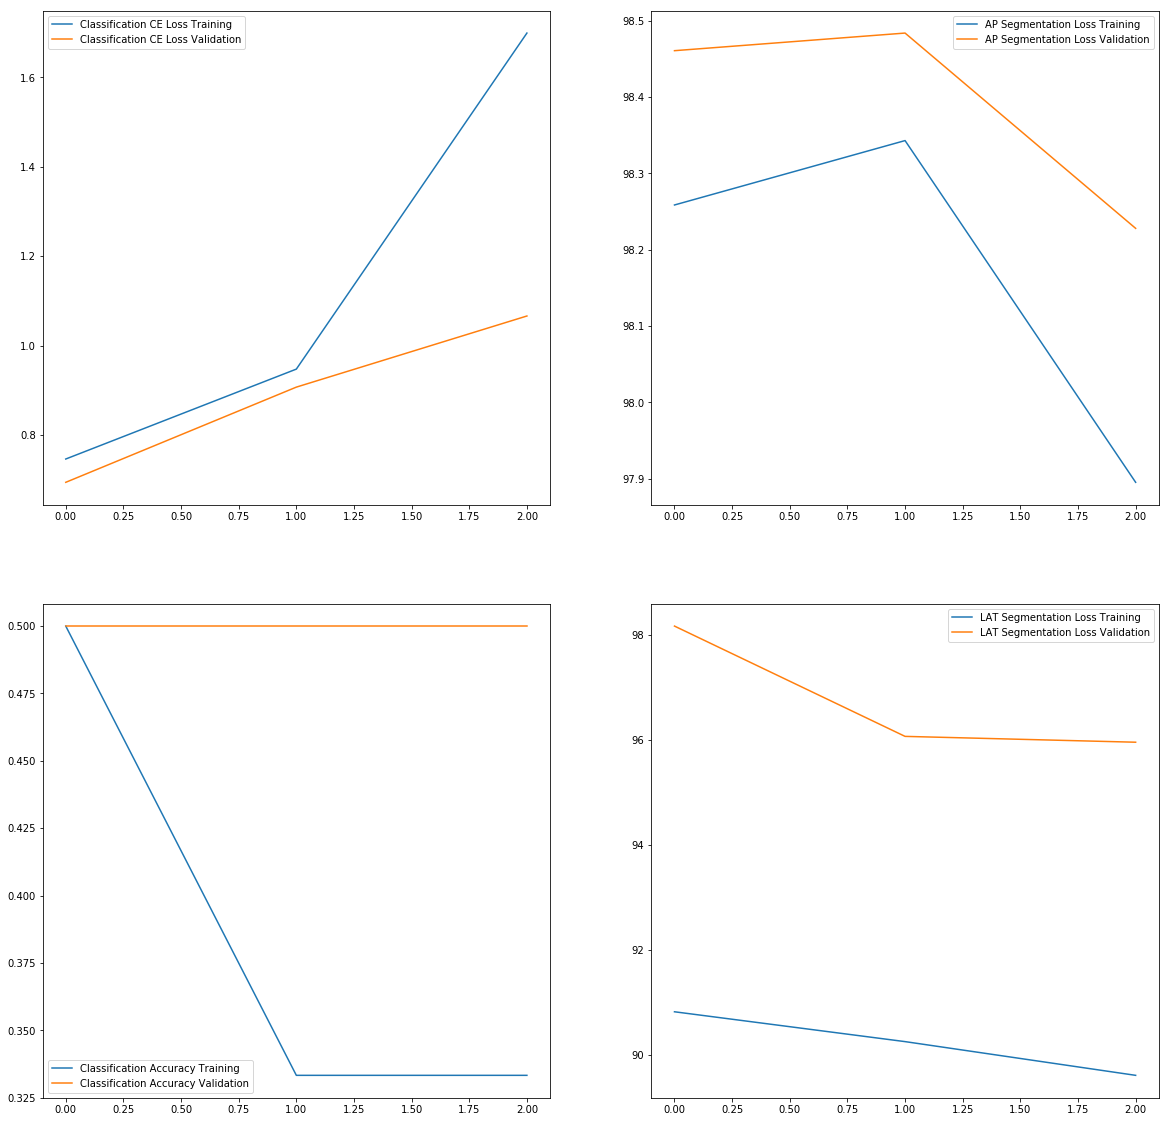

In [28]:
fig, ax = plt.subplots(2, 2, figsize = (20, 20))
ax[0, 1].plot(seg1_train_loss_array, label = "AP Segmentation Loss Training")
ax[0, 1].plot(seg1_val_loss_array, label = "AP Segmentation Loss Validation")
ax[0, 1].legend()

ax[1, 1].plot(seg2_train_loss_array, label = "LAT Segmentation Loss Training")
ax[1, 1].plot(seg2_val_loss_array, label = "LAT Segmentation Loss Validation")
ax[1, 1].legend()

ax[0, 0].plot(ce_train_loss_array, label = "Classification CE Loss Training")
ax[0, 0].plot(ce_val_loss_array, label = "Classification CE Loss Validation")
ax[0, 0].legend()

ax[1, 0].plot(correct_array, label = "Classification Accuracy Training")
ax[1, 0].plot(val_correct_array, label = "Classification Accuracy Validation")
ax[1, 0].legend()

plt.show()

### Model Save Dict

In [ ]:
torch.save(model.state_dict(), "total_seg_class_model_v1_3")